## Import Dependencies

In [1]:
import torch
import cv2 as cv
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm

In [27]:
import warnings
warnings.filterwarnings("ignore")

## Downloading YOLO

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model

Using cache found in /Users/mohamedmafaz/.cache/torch/hub/ultralytics_yolov5_master
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
/bin/sh: pip: command not found
requirements: ❌ Command 'pip install --no-cache "gitpython>=3.1.30" "setuptools>=65.5.1" ' returned non-zero exit status 127.
YOLOv5 🚀 2023-9-24 Python-3.11.5 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Importing Lookup table and preporcessing it

In [3]:
data_cam1 = pd.read_csv("walk_data_cam1.csv")
data_cam1.LocX = data_cam1.LocX.str.replace("[" , "").astype("float64")
data_cam1.LocZ = data_cam1.LocZ.str.replace("]" , "").astype("float64")
data_cam1 = data_cam1.drop(columns="LocZ" , axis=1)
data_cam1

,Frame,Distance,LocX,LocY
0,1,50.568724,-0.211293,8.121851
1,2,50.568724,-0.211293,8.121851
2,3,50.566764,-0.209846,8.107642
3,4,50.552435,-0.199176,8.002850
4,5,50.538319,-0.188506,7.898057
...,...,...,...,...
225,226,37.381474,-12.884773,-8.529395
226,227,37.288935,-12.987406,-8.553098
227,228,37.196470,-13.090038,-8.576802
228,229,37.104070,-13.192671,-8.600506


## Adding bbox's Center , LocX and LocY 

In [5]:
null_encounters = 0

for cam in ["Cam1"]:

    center_x = []
    center_y = []
    area = []


    for frame in tqdm(range(1,230 + 1)):
        link = f"{cam}/cam_1{frame:04d}.png"

        if model(cv.imread(link)).xywh[0].shape[0] != 0:
            x , y , w , h = model(cv.imread(link)).xywh[0][0][:4]
            x , y , w , h = float(x) , float(y) , float(w) , float(h)
            center_x.append((x + (w / 2)))
            center_y.append((y + (h / 2)))
            area.append((w * h))
            
        else:

            null_encounters += 1
            if cam == "Cam1":
                data_cam1 = data_cam1[data_cam1.Frame != frame]
            elif cam == "Cam2":
                data_cam2 = data_cam2[data_cam2.Frame != frame]

    if cam == "Cam1":
        data_cam1["Center_x"] = center_x
        data_cam1["Center_y"] = center_y
        data_cam1["Area"] = area
    elif cam == "Cam2":
        data_cam2["Center_x"] = center_x
        data_cam2["Center_y"] = center_y
        data_cam2["Area"] = area





100%|██████████| 230/230 [00:36<00:00,  6.25it/s]


In [7]:
data_cam1

,Frame,Distance,LocX,LocY,Center_x,Center_y,Area
0,1,50.568724,-0.211293,8.121851,1559.256958,292.132660,4720.890720
1,2,50.568724,-0.211293,8.121851,1559.697327,291.870598,4757.625006
2,3,50.566764,-0.209846,8.107642,1559.552795,289.603569,4442.816539
3,4,50.552435,-0.199176,8.002850,1562.484741,294.834953,4705.562976
4,5,50.538319,-0.188506,7.898057,1565.834106,296.199585,4563.729400
...,...,...,...,...,...,...,...
222,223,37.659485,-12.576876,-8.458282,634.831024,800.618195,7090.247925
226,227,37.288935,-12.987406,-8.553098,611.717621,797.455780,13596.465677
227,228,37.196470,-13.090038,-8.576802,607.908752,803.530548,15781.840525
228,229,37.104070,-13.192671,-8.600506,606.280914,810.282410,17461.162368


## Function to get Distance(from camera to person) and LocX and LocY corresponding to it

In [9]:
def get_dis_Loc(link : str , look_up_table : pd.core.frame.DataFrame , h_ = 1.6 , f = 1714) -> tuple[float , float , float]:
  """
  Input : Gets Image
  Output : relates it to lookup table and gets LocX and LocY

  """

  d_ , LocX , LocY = 0 , 0 , 0

  link = link
  img = cv.imread(link)
  result = model(img)
  if result.xyxy[0].shape[0] != 0:

    cordinates = result.xywh[0].cpu().numpy()[0]
    
    Center_x = cordinates[0] + (cordinates[2] / 2)
    Center_y = cordinates[1] + (cordinates[3] / 2)

    d_ = (h_ * f / cordinates[3])
    look_up_table["difference_"] = abs(look_up_table["Distance"] - d_)

    data_sub = look_up_table.copy()
    data_sub["Center_x_"] = abs(data_sub["Center_x"] - Center_x)
    data_sub["Center_y_"] = abs(data_sub["Center_y"] - Center_y)
    
    data_sub["Center_difference_"] = (data_sub["Center_x_"] + data_sub["Center_y_"])/2

    data_min = data_sub["Center_difference_"].idxmin()
    LocX = look_up_table.at[data_min , "LocX"]
    LocY = look_up_table.at[data_min , "LocY"]

   
  else:
    LocX = 0
    LocX = 0
    LocX = 0
  # If prediction doesnt happen then return prevous data as new (helps in keeping plotting in order)

  return d_ , LocX , LocY

### Testing focal length , and above function

In [10]:
f_cam1 = (36.7 * 167.28) / 1.6
f_cam1

3836.985

In [19]:
f"Cam1_disorted/frame-{230:06d}.png" 

'Cam1_disorted/frame-000230.png'

In [32]:
d_ , LocX , LocY  = get_dis_Loc(link = f"Cam1_disorted/frame-{181:06d}.png" , look_up_table = data_cam1 , h_ = 1.6 , f = f_cam1)
d_ , LocX , LocY 
print(f"Predicted distance (Camera to person) : {d_}\nPredicted Location X : {LocX}\nPredicted Location Y : {LocY}")

Predicted distance (Camera to person) : 38.279562777460846
Predicted Location X : -8.498136520385742
Predicted Location Y : -7.06275272369385


In [29]:
print(f"Actaul distance (Camera to person) : {float(data_cam1[data_cam1.Frame == 182].Distance)}\nPredicted Location X : {float(data_cam1[data_cam1.Frame == 230].LocX)}\nPredicted Location Y : {float(data_cam1[data_cam1.Frame == 182].LocY)}")

Actaul distance (Camera to person) : 41.35443249416031
Predicted Location X : -13.29530143737793
Predicted Location Y : -7.06275272369385


### Function to patch UNIDENTIFIED Distance, Location

In [35]:
def patch_prev(List : list , find , replace = None):
    """
    Replaces the "find" with the previous value
    """
    track = None
    for index in range(len(List)):
        if List[index] == find:
            if index == 0:
                raise Exception("First index cannot be the one to replace")
            else:
                if replace is None:
                    List[index] = track
                else:
                    List[index] = replace
        
        track = List[index]
    return List

# Plotting

In [71]:
LocX_disorted_cam1 = []
LocY_disorted_cam1 = []
distance_cam1 = []

for frame in tqdm(range(1 , 230 + 1)) :
    link = f"Cam1_disorted/frame-{frame:06d}.png"
    # print(link)
    d_ , LocX , LocY = get_dis_Loc(link = link , look_up_table = data_cam1 , h_ = 1.6 , f = f_cam1)
    LocX_disorted_cam1.append(LocX)
    LocY_disorted_cam1.append(LocY)
    distance_cam1.append(d_)

100%|██████████| 230/230 [00:21<00:00, 10.56it/s]


In [72]:
LocX_disorted_cam1 = patch_prev(LocX_disorted_cam1 , find = 0)
LocY_disorted_cam1 = patch_prev(LocY_disorted_cam1 , find = 0)
distance_disorted_cam1 = patch_prev(distance_cam1 , find = 0)

In [73]:
LocX_disorted_cam1 = [i + 0.3 for i in LocX_disorted_cam1]
LocY_disorted_cam1 = [i + 0.4 for i in LocY_disorted_cam1]

# Actaul Path took vs Predicted Path

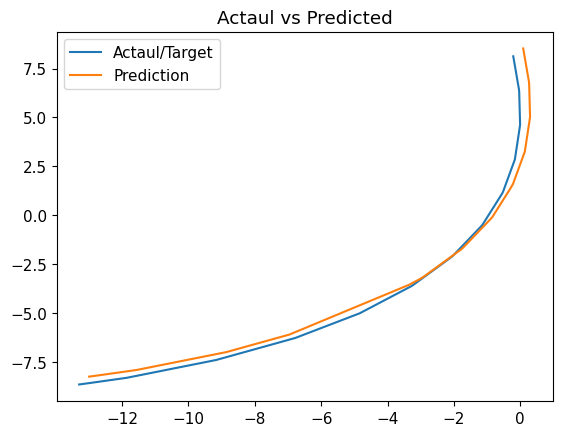

In [76]:
plt.plot(data_cam1.LocX , data_cam1.LocY , label = "Actaul/Target")
plt.plot(LocX_disorted_cam1 , LocY_disorted_cam1 , label = "Prediction")
plt.legend()
plt.title("Actaul vs Predicted")
plt.show()

# Dealing with Reidentification

In [79]:
from skimage.metrics import structural_similarity 

def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 40]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)


#Needs images to be same dimensions
def structural_sim(img1, img2):

  sim, diff = structural_similarity(img1, img2, full=True)
  return sim

## Rendering Image Sequence

In [90]:
LocX_disorted_cam1 = []
LocY_disorted_cam1 = []
distance_cam1 = []

name = "Person1"
for frame in tqdm(range(1 , 230+1)) :
    link = f"Cam1_disorted/frame-{frame:06d}.png"
    img = cv.imread(link)
    result = model(img)

    xyxy = []
    if result.xyxy[0].shape[0] != 0:
        for i in result.xyxy[0][0][:4]:
            xyxy.append(int(i))

        img_cropped = (img[xyxy[1] - 50 : xyxy[3] + 50 , xyxy[0] - 50 : xyxy[2] + 50])
        if frame < 10:
            cv.imwrite("Person1.png" , img_cropped)
        else:
            orb_similarity = orb_sim(cv.imread("Person1.png"), img_cropped)
            if orb_similarity < 70:
                name = "Person1"
            else:
                cv.imwrite("Different Person.png" , img_cropped)
                name = "Different Person"
        
        img = cv.rectangle(img , [xyxy[0] , xyxy[1]] , [xyxy[2] , xyxy[3]] , color = (0,255,20) , thickness=1)
        img = cv.putText(img , name , [xyxy[0] , xyxy[1]] , cv.FONT_HERSHEY_COMPLEX , 2 , (200,0,0) , 1)
    cv.imwrite(f"Disorted_output/Disorted_cam1_{frame}.png" , img)
    
    

100%|██████████| 230/230 [00:30<00:00,  7.54it/s]
